In [1]:
!pip install beautifulsoup4
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes 
!pip install lxml
import requests 
import pandas as pd 
import numpy as np 
import random 


from geopy.geocoders import Nominatim 

from pandas.io.json import json_normalize

import folium 
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

     |████████████████████████████████| 122kB 7.8MB/s eta 0:00:01
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    fo

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup=BeautifulSoup(source,'lxml')
print(soup.title)
AllCode = str(soup.table)
temp = pd.read_html(AllCode)
df=temp[0]
df.head()

<title>List of postal codes of Canada: M - Wikipedia</title>


,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
df1 = df[df.Borough != 'Not assigned']
df2 = df1.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])


In [4]:
latlon = pd.read_csv('https://cocl.us/Geospatial_data')
latlon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
df3 = pd.merge(df2,latlon,on='Postal Code')
df3=df3.drop(columns="Postal Code")
df3.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


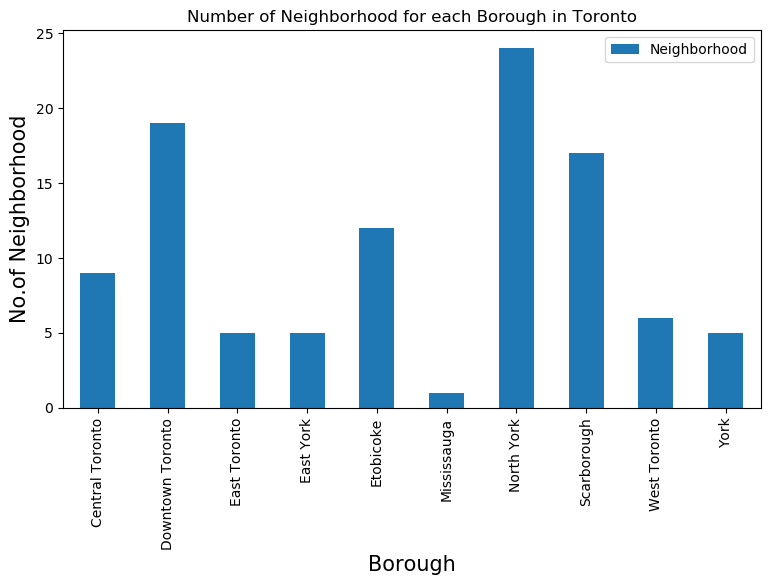

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
df3.groupby(['Borough'])['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [7]:
##Turns address into lat and long
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [11]:
CLIENT_ID = 'JRUA0X450G0SI4C2XNP2WFNBFSUM0BO151G10QBK45KNXEFW' #Foursquare ID
CLIENT_SECRET = 'J3FF5L0IW0WA4X4KUX2TRODVR2QYJH4LMQDHL324DEQSPZ2R' #Foursquare Secret
VERSION = '20180605' # Foursquare API version
def get_venues(lat,lng):
    
    #set variables
    radius=750
    LIMIT=100
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    #get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [12]:

def get_venue_details(venue_id):
        
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [13]:
# prepare neighborhood list that contains indian resturants in toronto
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest=pd.DataFrame(columns=column_names)
count=1
for row in df3.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df3),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest = indian_rest.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indian Resturants in Parkwoods, North York:0
( 2 / 103 ) Indian Resturants in Victoria Village, North York:0
( 3 / 103 ) Indian Resturants in Regent Park, Harbourfront, Downtown Toronto:0
( 4 / 103 ) Indian Resturants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Indian Resturants in Queen's Park, Ontario Provincial Government, Downtown Toronto:1
( 6 / 103 ) Indian Resturants in Islington Avenue, Humber Valley Village, Etobicoke:0
( 7 / 103 ) Indian Resturants in Malvern, Rouge, Scarborough:0
( 8 / 103 ) Indian Resturants in Don Mills, North York:0
( 9 / 103 ) Indian Resturants in Parkview Hill, Woodbine Gardens, East York:0
( 10 / 103 ) Indian Resturants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 103 ) Indian Resturants in Glencairn, North York:0
( 12 / 103 ) Indian Resturants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 103 ) Indian Resturants in Rouge Hill, Port Union, Highland Creek, Scarboroug

In [14]:
indian_rest.head()

,Borough,Neighborhood,ID,Name
0,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4bedf8b5e24d20a17b567214,Kothur Indian Cuisine
1,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro
2,East York,Leaside,504bcf32e4b0ef19b0e2ecf8,Mt Everest Restaurant
3,Downtown Toronto,Christie,4adb969ef964a520332921e3,Banjara Indian Cuisine
4,Downtown Toronto,Christie,4b7369d7f964a52049ad2de3,Madras Masala


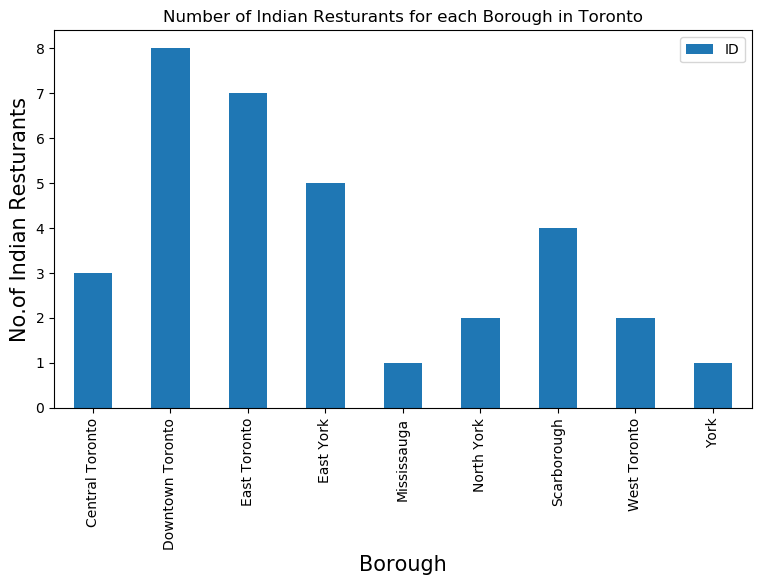

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

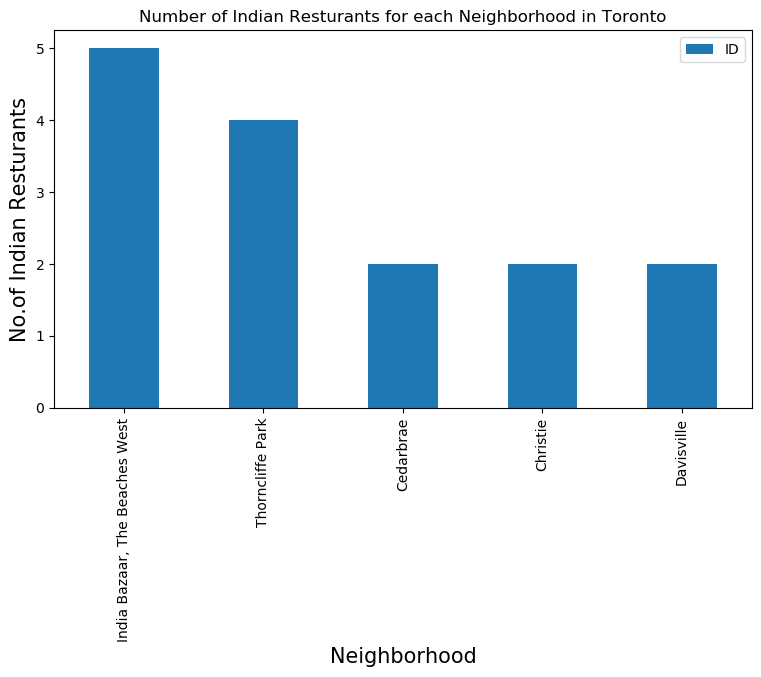

In [18]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in Toronto')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [22]:
indian_rest[indian_rest['Neighborhood']=='India Bazaar, The Beaches West']

,Borough,Neighborhood,ID,Name
13,East Toronto,"India Bazaar, The Beaches West",4ae0c7a8f964a520638221e3,Udupi Palace
14,East Toronto,"India Bazaar, The Beaches West",4afc9816f964a520312422e3,Motimahal
15,East Toronto,"India Bazaar, The Beaches West",4ad9052cf964a520301721e3,Regency Restaurant
16,East Toronto,"India Bazaar, The Beaches West",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
17,East Toronto,"India Bazaar, The Beaches West",4d8d278a1d06b1f712942a3b,Gautama


In [23]:

# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest),')','processed')
    indian_rest_stats = indian_rest_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                   Name  Likes  Rating  Tips
0  4bedf8b5e24d20a17b567214  Kothur Indian Cuisine     16     8.0    19
( 1 / 33 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dcd7c6352b1f8915b7e7f7e  Delhi Bistro      6     6.9     3
( 2 / 33 ) processed
                         ID                   Name  Likes  Rating  Tips
0  504bcf32e4b0ef19b0e2ecf8  Mt Everest Restaurant      8     6.8     6
( 3 / 33 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4adb969ef964a520332921e3  Banjara Indian Cuisine    142     8.7    75
( 4 / 33 ) processed
                         ID           Name  Likes  Rating  Tips
0  4b7369d7f964a52049ad2de3  Madras Masala     35     8.1    22
( 5 / 33 ) processed
                         ID             Name  Likes  Rating  Tips
0  4d6008f829ef236a8832a059  CANBE Foods Inc     22     8.3     8
( 6 / 33 ) processed
                         ID           Name  Likes  Rat

In [24]:
indian_rest_stats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Downtown Toronto,"Queen's Park, Ontario Provincial Government",4bedf8b5e24d20a17b567214,Kothur Indian Cuisine,16,8.0,19
1,East Toronto,The Beaches,4dcd7c6352b1f8915b7e7f7e,Delhi Bistro,6,6.9,3
2,East York,Leaside,504bcf32e4b0ef19b0e2ecf8,Mt Everest Restaurant,8,6.8,6
3,Downtown Toronto,Christie,4adb969ef964a520332921e3,Banjara Indian Cuisine,142,8.7,75
4,Downtown Toronto,Christie,4b7369d7f964a52049ad2de3,Madras Masala,35,8.1,22


In [26]:
##  Puts the right data format
indian_rest_stats['Likes']=indian_rest_stats['Likes'].astype('float64')
indian_rest_stats['Tips']=indian_rest_stats['Tips'].astype('float64')

In [27]:
neighborhood_stats=indian_rest_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']

In [28]:
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
16,"The Annex, North Midtown, Yorkville",8.7
3,Christie,8.4
8,"High Park, The Junction South",8.3
4,Church and Wellesley,8.0
12,"Queen's Park, Ontario Provincial Government",8.0
10,"Kensington Market, Chinatown, Grange Park",7.8
2,Cedarbrae,7.7
7,"Harbourfront East, Union Station, Toronto Islands",7.4
0,"Bedford Park, Lawrence Manor East",7.3
5,Davisville,7.3


In [30]:
neighborhood_stats=neighborhood_stats[neighborhood_stats['Average Rating']>=7.5]
neighborhood_stats

,Neighborhood,Average Rating
2,Cedarbrae,7.7
3,Christie,8.4
4,Church and Wellesley,8.0
8,"High Park, The Junction South",8.3
10,"Kensington Market, Chinatown, Grange Park",7.8
12,"Queen's Park, Ontario Provincial Government",8.0
16,"The Annex, North Midtown, Yorkville",8.7


In [31]:
neighborhood_stats=pd.merge(neighborhood_stats,df3, on='Neighborhood')
neighborhood_stats=neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Scarborough,Cedarbrae,43.773136,-79.239476,7.7
1,Downtown Toronto,Christie,43.669542,-79.422564,8.4
2,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,8.0
3,West Toronto,"High Park, The Junction South",43.661608,-79.464763,8.3
4,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,7.8
5,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8.0
6,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,8.7


AttributeError: 'str' object has no attribute 'drop'

TypeError: string indices must be integers